In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost

In [3]:
playR = pd.read_csv("../../data/other_data_for_20_cll/concattransformedPlayRWithLabel.csv", index_col = 0)

In [5]:
playR = playR[playR['label'] != 10 ]

In [7]:
# playR['classes'] = np.where(playR['label'].isin([3,1,2]), 0,
#                  np.where(playR['label'] == 8, 1, 2))

playR['classes'] = np.where(playR['label'].isin([3,1,2, 8]), 1, 0)

In [9]:
playR.classes.unique()

array([1, 0])

In [11]:
df = playR

In [13]:
df['classes'].value_counts()

0    54530
1    15776
Name: classes, dtype: int64

In [15]:
min_count = df['classes'].value_counts().min()

# Downsample each category
df_downsampled = pd.concat([
    resample(df[df['classes'] == cat], replace=False, n_samples=min_count, random_state=42)
    for cat in df['classes'].unique()
])

In [17]:
value_counts = df_downsampled['classes'].value_counts()

print(value_counts)

1    15776
0    15776
Name: classes, dtype: int64


In [23]:
df_downsampled = df_downsampled.drop(["label", "Ki67", "MYC"], axis = 1)
X = df_downsampled.drop(columns=['classes'])  # Drop the label column to get only features
y = df_downsampled['classes']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9392
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4656
           1       0.93      0.95      0.94      4810

    accuracy                           0.94      9466
   macro avg       0.94      0.94      0.94      9466
weighted avg       0.94      0.94      0.94      9466



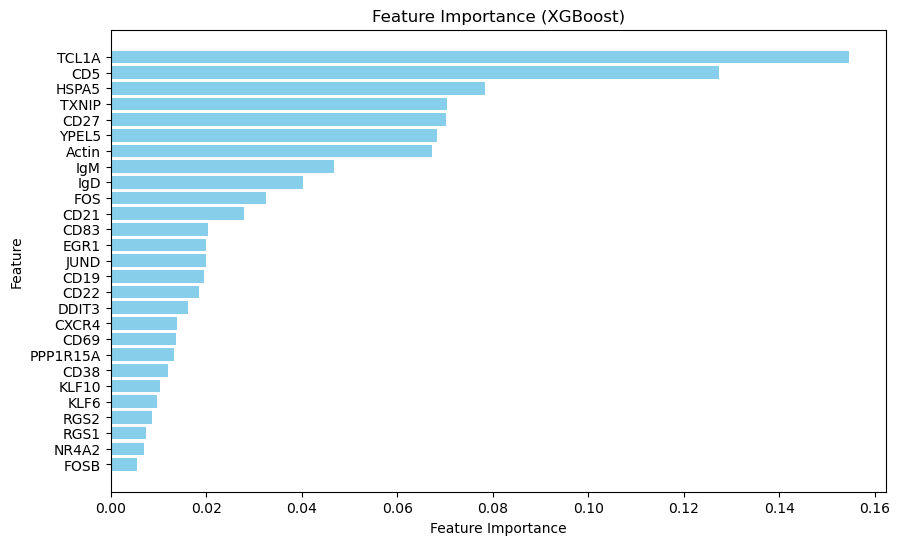

In [29]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.show()

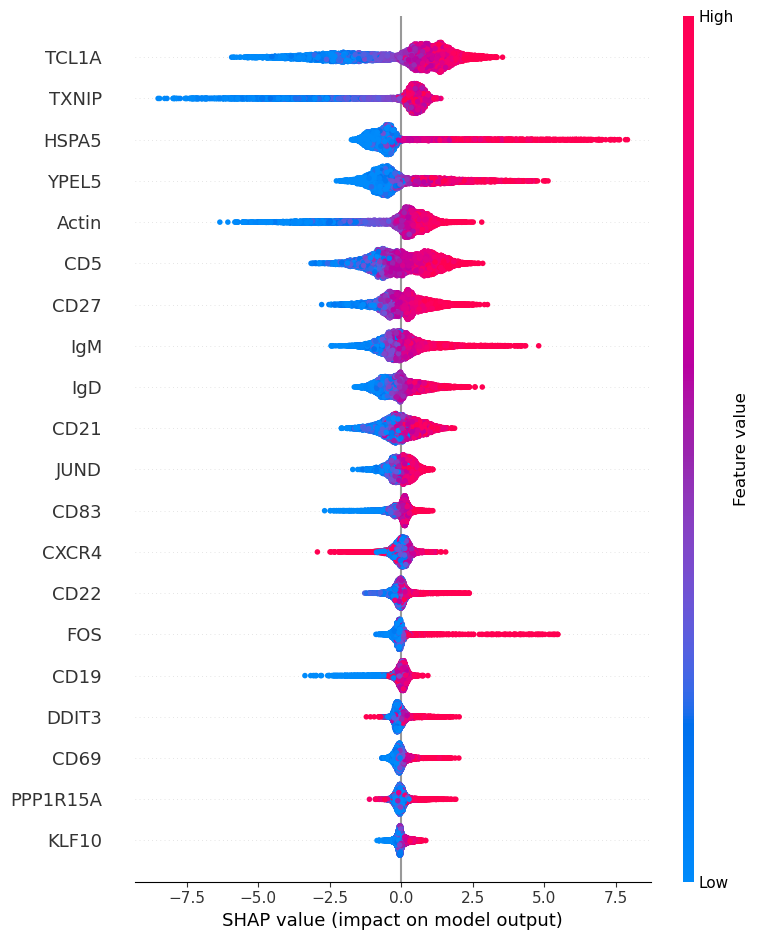

In [31]:
import shap
# Initialize SHAP Explainer
# explainer = shap.TreeExplainer(model)

# # Calculate SHAP values for test data
# shap_values = explainer.shap_values(X_test)

# # Visualize the SHAP summary plot
# shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, max_display = 10, plot_type="bar")

# Visualize the SHAP dependence plot for a specific feature
#shap.dependence_plot(0, shap_values, X_test, feature_names=df_imputed.columns)

# Explain model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, )

# Alternative summary plot (bar chart)
#shap.summary_plot(shap_values, X_test, plot_type="bar")

 99%|===================| 21961/22086 [01:23<00:00]        

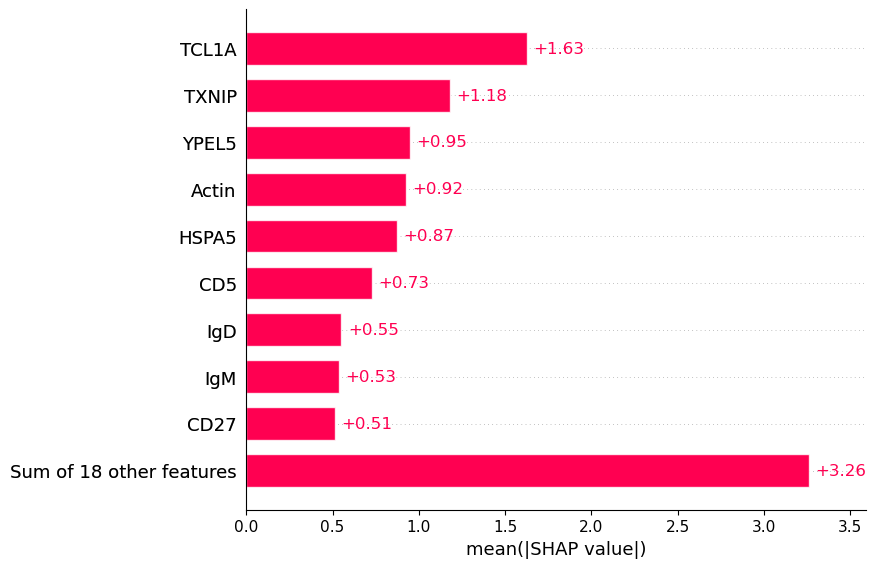

In [15]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

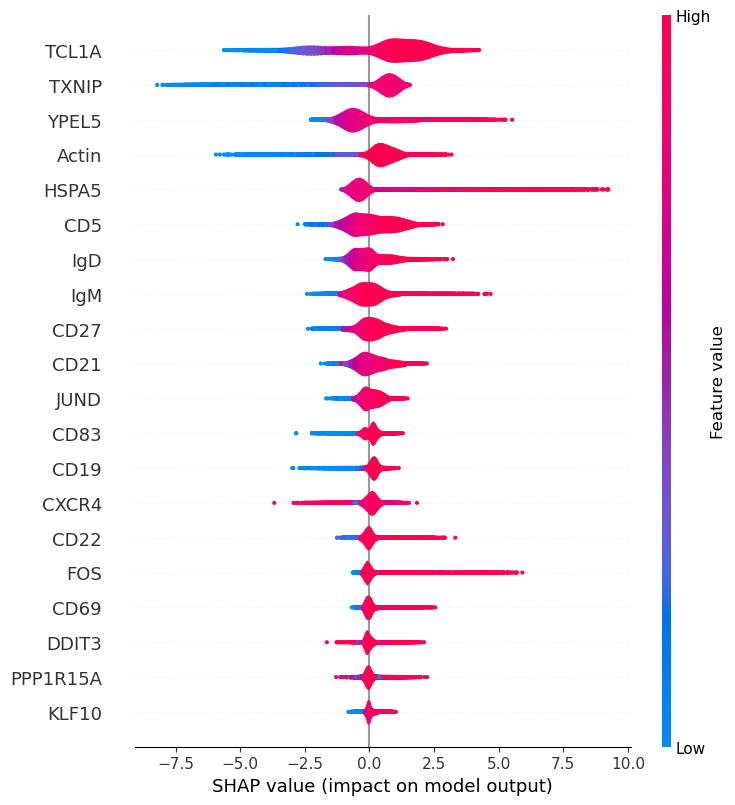

In [16]:
shap.plots.violin(shap_values, feature_names = list(X_train.columns))

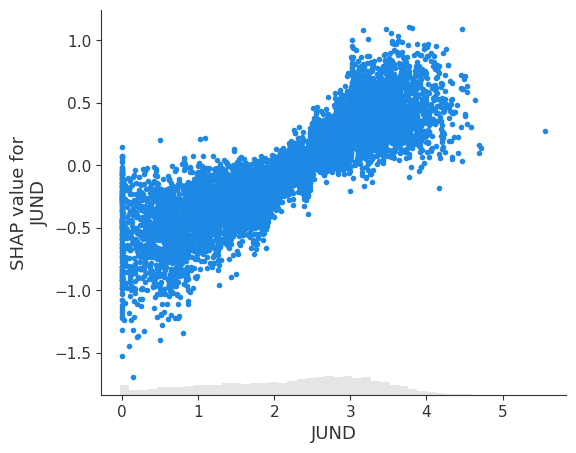

In [39]:
feature_name = 'JUND'
shap.plots.scatter(shap_values[:, feature_name])